In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from wordcloud import WordCloud
from sklearn.utils.class_weight import compute_class_weights
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score

# Data Loading and Initial Exploration

This section loads the financial news dataset and displays the first few rows to get an initial understanding of the data structure.

In [53]:
pd.set_option("display.max_columns", None)

df = pd.read_csv("financial_news_events.csv", parse_dates=["Date"])
df.head()

,Date,Headline,Source,Market_Event,Market_Index,Index_Change_Percent,Trading_Volume,Sentiment,Sector,Impact_Level,Related_Company,News_Url
0,2025-05-21,Nikkei 225 index benefits from a weaker yen,Times of India,Commodity Price Shock,DAX,3.52,166.45,NaN,Technology,High,Goldman Sachs,https://timesofindia.indiatimes.com/business/m...
1,2025-05-18,Government subsidy program gives a lift to the...,Financial Times,Central Bank Meeting,Shanghai Composite,-3.39,57.61,NaN,Retail,Low,ExxonMobil,https://timesofindia.indiatimes.com/business/m...
2,2025-06-25,New housing data release shows a slowdown in m...,The Hindu Business Line,Consumer Confidence Report,Shanghai Composite,-0.05,403.22,Neutral,Retail,Medium,Boeing,https://www.moneycontrol.com/us-markets/sp-500
3,2025-07-21,Massive stock buyback program announced by a c...,The Economist,Commodity Price Shock,NSE Nifty,-2.29,100.11,Positive,Consumer Goods,Low,Samsung Electronics,https://www.cnbc.com/2025/09/automotive-indust...
4,2025-07-23,Government spending bill is expected to stimul...,The Motley Fool,Inflation Data Release,Nasdaq Composite,-3.97,438.22,Negative,Consumer Goods,Low,JP Morgan Chase,https://www.bloomberg.com/australia/asx-200-pe...


# Data Inspection and Missing Values Analysis

This section provides a comprehensive look at the dataset structure and identifies missing values.


In [54]:
display(df.info())
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024 entries, 0 to 3023
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  3024 non-null   datetime64[ns]
 1   Headline              2876 non-null   object        
 2   Source                3024 non-null   object        
 3   Market_Event          3024 non-null   object        
 4   Market_Index          3024 non-null   object        
 5   Index_Change_Percent  2863 non-null   float64       
 6   Trading_Volume        3024 non-null   float64       
 7   Sentiment             2853 non-null   object        
 8   Sector                3024 non-null   object        
 9   Impact_Level          3024 non-null   object        
 10  Related_Company       3024 non-null   object        
 11  News_Url              2871 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(9)
memory usage: 283.6+ KB


None

Date                      0
Headline                148
Source                    0
Market_Event              0
Market_Index              0
Index_Change_Percent    161
Trading_Volume            0
Sentiment               171
Sector                    0
Impact_Level              0
Related_Company           0
News_Url                153
dtype: int64

# Data Cleaning and Preparation

This section handles missing data and ensures proper data types for analysis.


In [55]:
# Drop rows where Headline is empty
df = df[df["Headline"].notna()].reset_index(drop=True)

# Ensure numeric columns are numeric
num_cols = ["Index_Change_Percent", "Trading_Volume"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Fill missing sentiment with a new label
df["Sentiment"] = df["Sentiment"].fillna("Unknown")

# Missing Data Visualization

This section creates a heatmap visualization to better understand the distribution of missing values across columns.

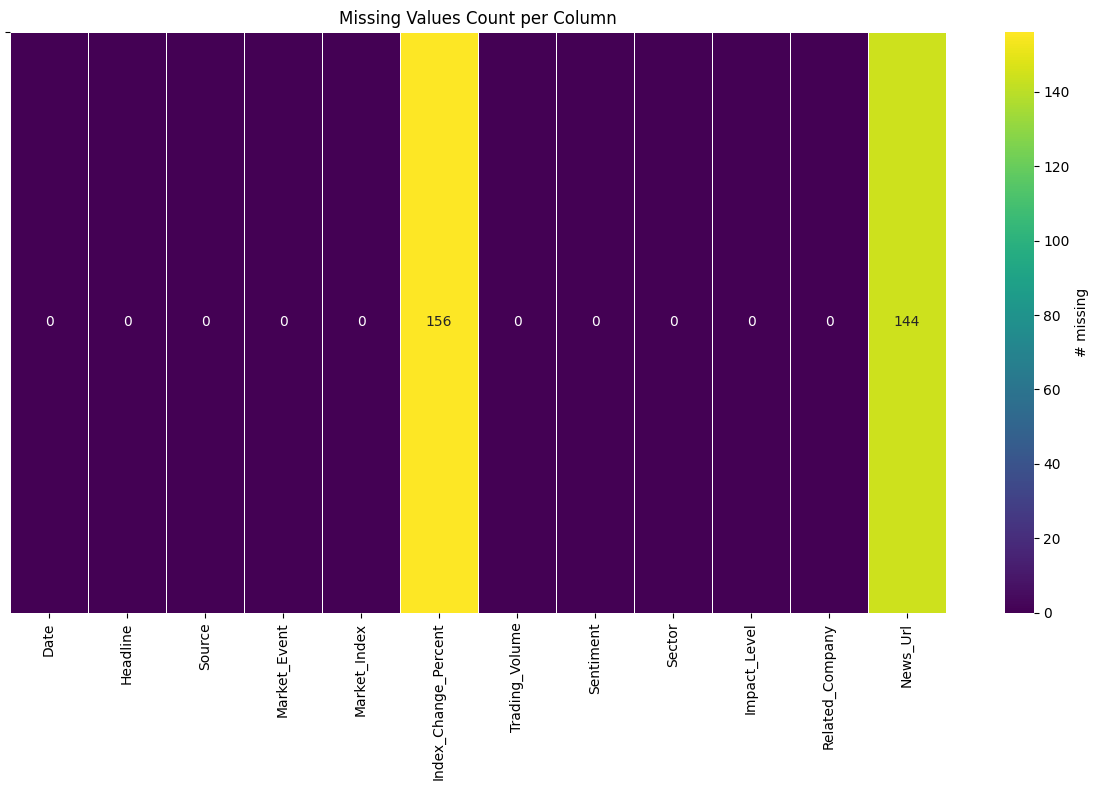

In [ ]:

plt.figure(figsize=(12, 8))          
sns.heatmap(
    df.isna().sum().to_frame().T,      # single row, one bar per column
    cmap="viridis",
    cbar_kws={'label': "# missing"},
    linewidths=0.5,
    annot=True,
    fmt="g"
)
plt.title("Missing Values Count per Column")
plt.yticks([0], [""])                 # hide y-axis
plt.tight_layout()
plt.show()


# Sentiment Distribution Analysis

This visualization examines the frequency distribution of sentiment labels in the financial news dataset.


/tmp/ipykernel_148328/3541796175.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="Sentiment", data=df, order=df["Sentiment"].value_counts().index,palette="Set2")


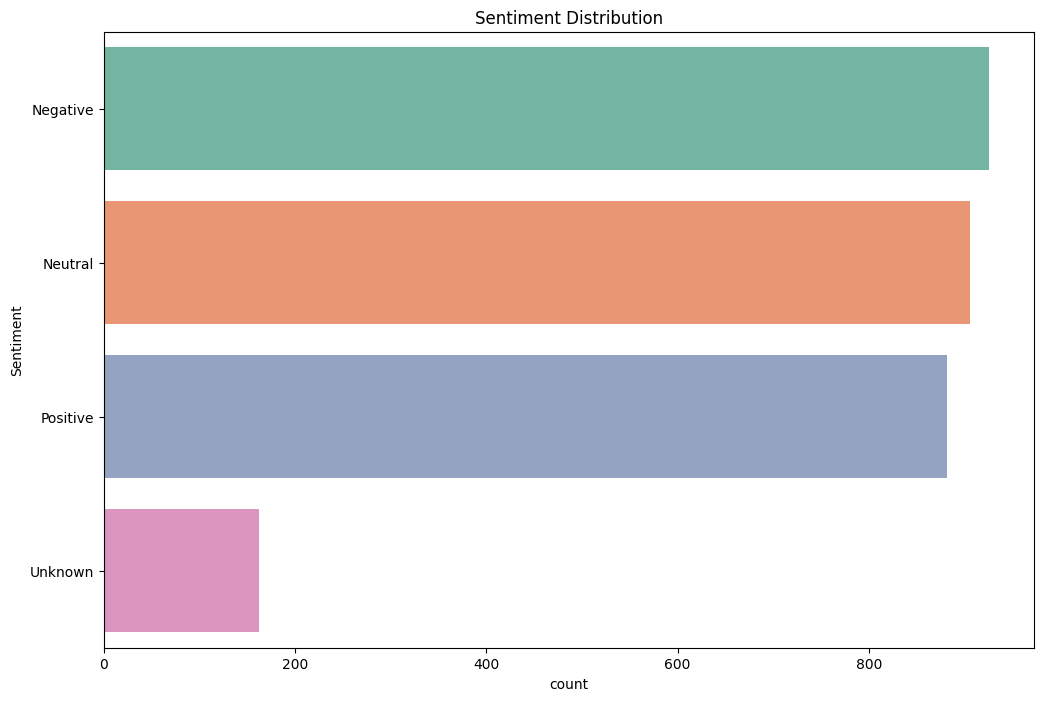

In [57]:
# 4b. Sentiment distribution
plt.figure(figsize=(12,8))
sns.countplot(y="Sentiment", data=df, order=df["Sentiment"].value_counts().index,palette="Set2")
plt.title("Sentiment Distribution")
plt.show()

# Sector Impact Analysis

This visualization examines the relationship between industry sectors and the impact level of financial news events.

<Figure size 1500x800 with 0 Axes>

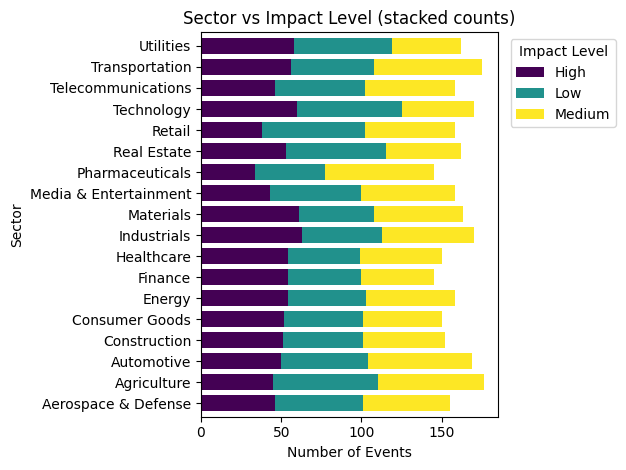

In [58]:

agg = (df
       .groupby(['Sector', 'Impact_Level'])
       .size()
       .unstack(fill_value=0))

plt.figure(figsize=(15, 8))
agg.plot(kind='barh', stacked=True, colormap='viridis', width=0.8)
plt.title("Sector vs Impact Level (stacked counts)")
plt.xlabel("Number of Events")
plt.legend(title="Impact Level", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Market Impact by Sentiment Analysis

This visualization examines the relationship between news sentiment and market index changes using a boxplot.


/tmp/ipykernel_148328/1150599650.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Sentiment", y="Index_Change_Percent", data=df,palette="viridis")


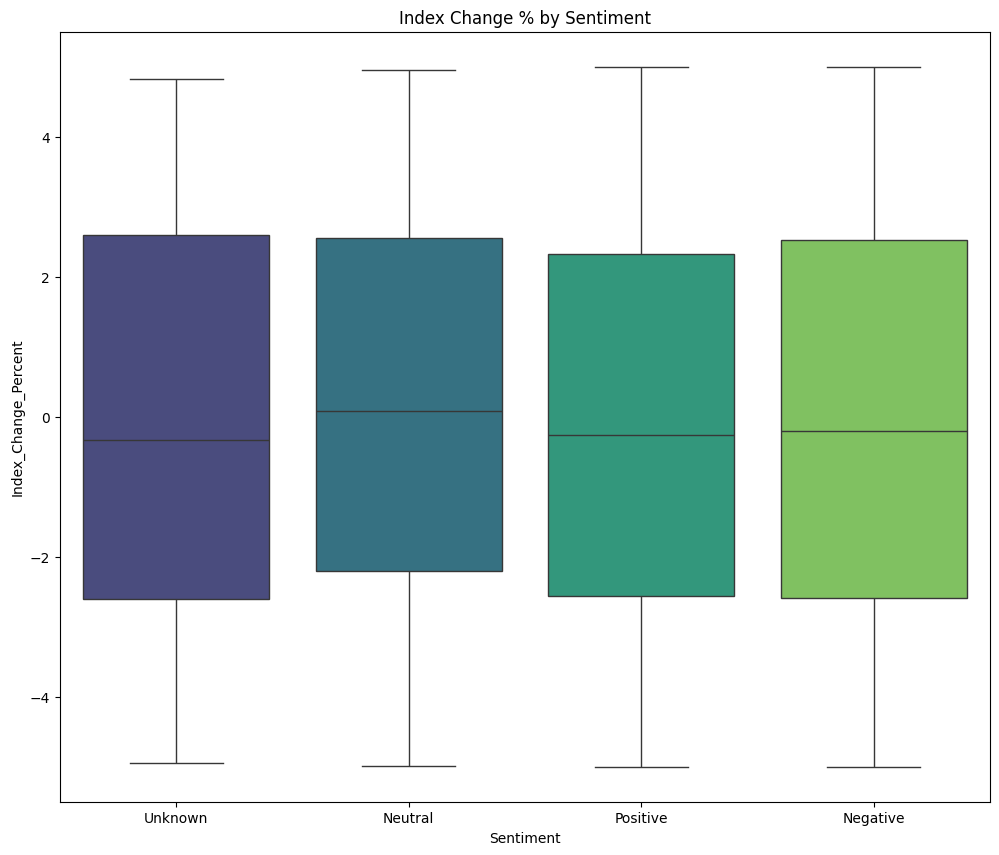

In [59]:
# 4d. Index change vs Sentiment
plt.figure(figsize=(12,10))
sns.boxplot(x="Sentiment", y="Index_Change_Percent", data=df,palette="viridis")
plt.title("Index Change % by Sentiment")
plt.show()


# Market Index Change Distribution Analysis

This visualization examines the frequency distribution of daily percentage changes in market indices.


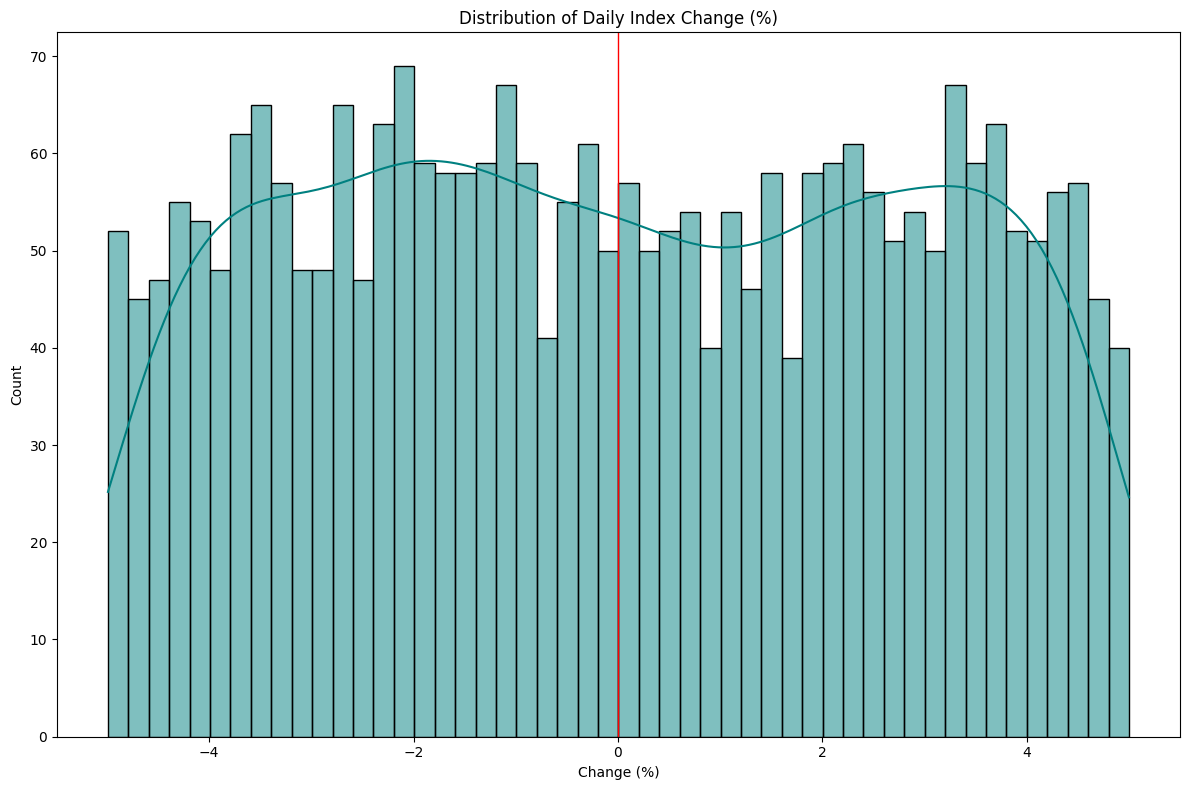

In [60]:

# %% [1]  Distribution of index-change %
plt.figure(figsize=(12,8))
sns.histplot(df['Index_Change_Percent'].dropna(), bins=50, kde=True, color='teal')
plt.axvline(0, color='red', lw=1)
plt.title("Distribution of Daily Index Change (%)")
plt.xlabel("Change (%)")
plt.tight_layout()
plt.show()


# Numeric Feature Correlation Analysis

This visualization examines relationships between all numerical variables in the dataset through a correlation matrix heatmap.

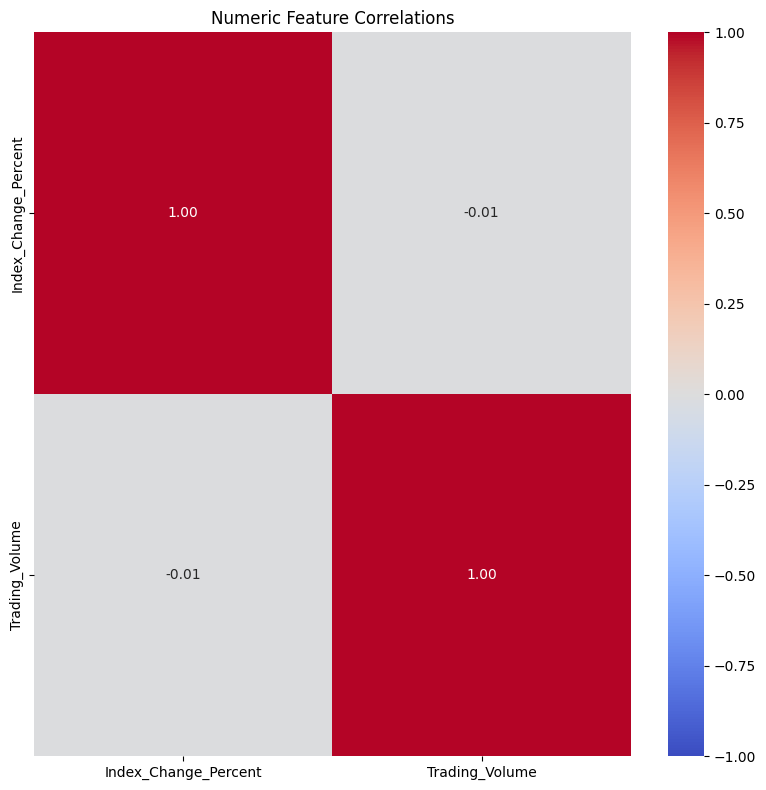

In [67]:
# %% [3]  Correlation heat-map (numeric cols only)
num_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(8,8))
sns.heatmap(num_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Numeric Feature Correlations")
plt.tight_layout()
plt.show()

# Sector-Sentiment Relationship Analysis

This visualization examines the interaction between industry sectors and news sentiment through a frequency heatmap.


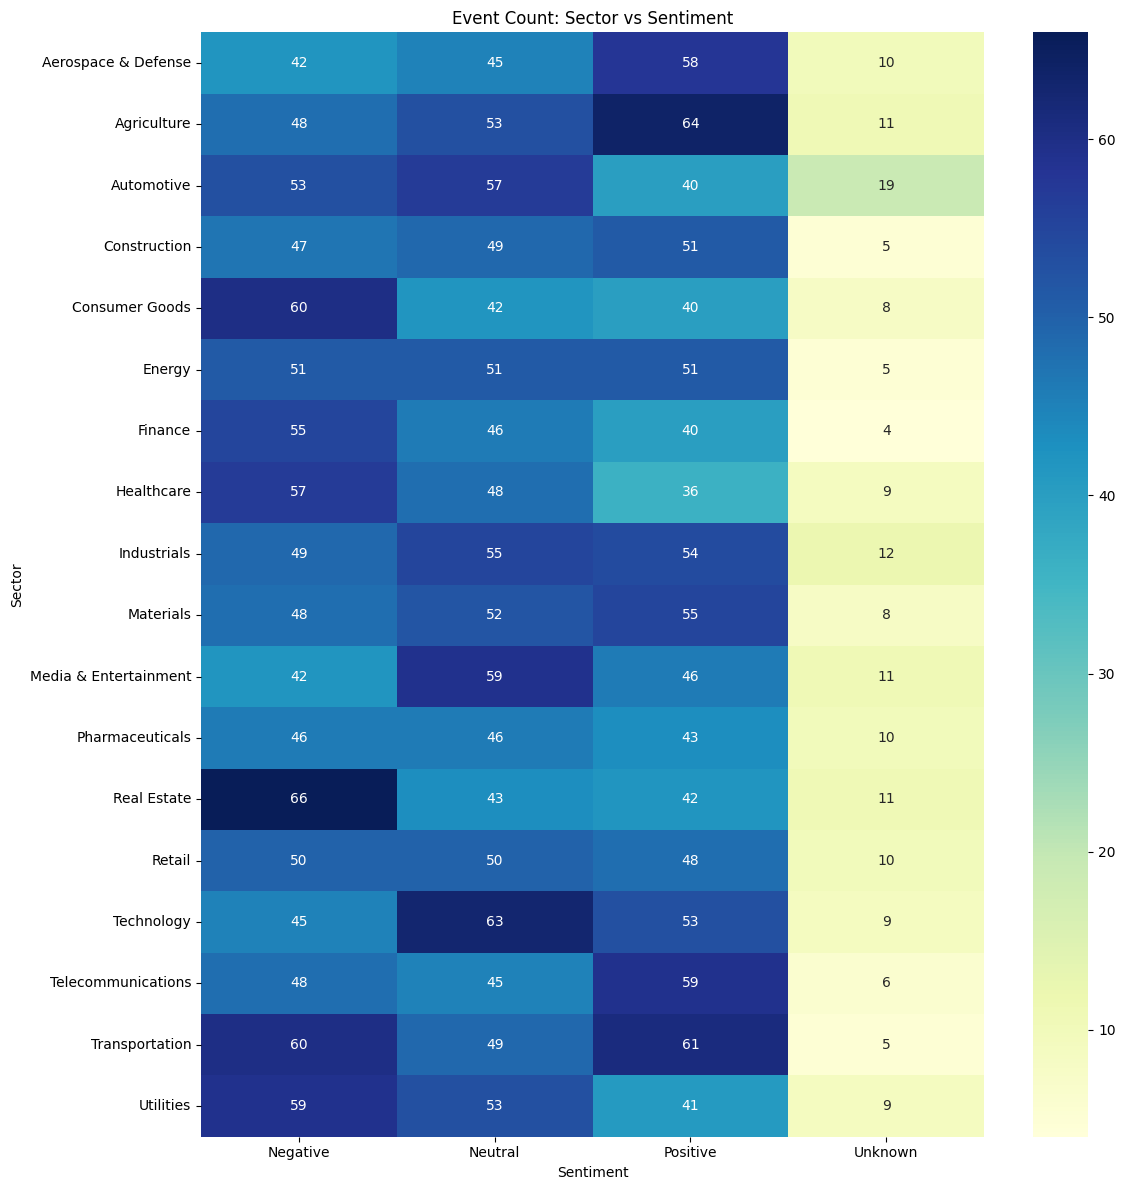

In [ ]:
pivot = pd.crosstab(df['Sector'], df['Sentiment'])
plt.figure(figsize=(12,12))
sns.heatmap(pivot, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Event Count: Sector vs Sentiment")
plt.ylabel("Sector")
plt.tight_layout()
plt.show()

# Financial Headline Word Cloud Analysis

This visualization identifies the most prominent terms appearing in financial news headlines using a word cloud representation.

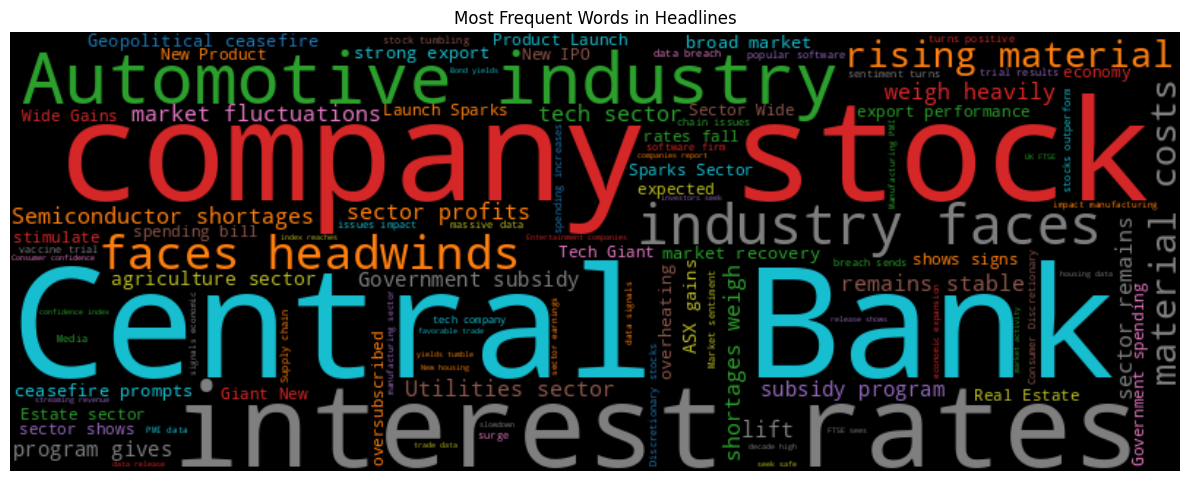

In [ ]:

text = " ".join(df['Headline'].dropna())
wc = WordCloud(width=800, height=300,
               background_color="black",
               colormap="tab10",
               max_words=100).generate(text)
plt.figure(figsize=(12,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in Headlines")
plt.tight_layout()
plt.show()

# Class-Weighted Logistic Regression Implementation

This code implements a logistic regression model with balanced class weights to handle imbalanced financial sentiment classes.


In [ ]:
# Compute balanced class weights
classes = np.unique(y)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y
)
class_weight_dict = dict(zip(classes, weights))

clf = LogisticRegression(max_iter=1000, class_weight=class_weight_dict)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.53      0.52      0.53       387
           1       0.46      0.47      0.46       332

    accuracy                           0.50       719
   macro avg       0.49      0.49      0.49       719
weighted avg       0.50      0.50      0.50       719



# Balanced Random Forest for Financial Sentiment Analysis

This implementation addresses class imbalance in financial sentiment prediction using a robust ensemble method.

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.53      0.51      0.52       387
           1       0.45      0.47      0.46       332

    accuracy                           0.49       719
   macro avg       0.49      0.49      0.49       719
weighted avg       0.49      0.49      0.49       719



# Precision-Recall Curve Analysis

This section evaluates our classification model using a Precision-Recall Curve, which is particularly useful for imbalanced datasets.


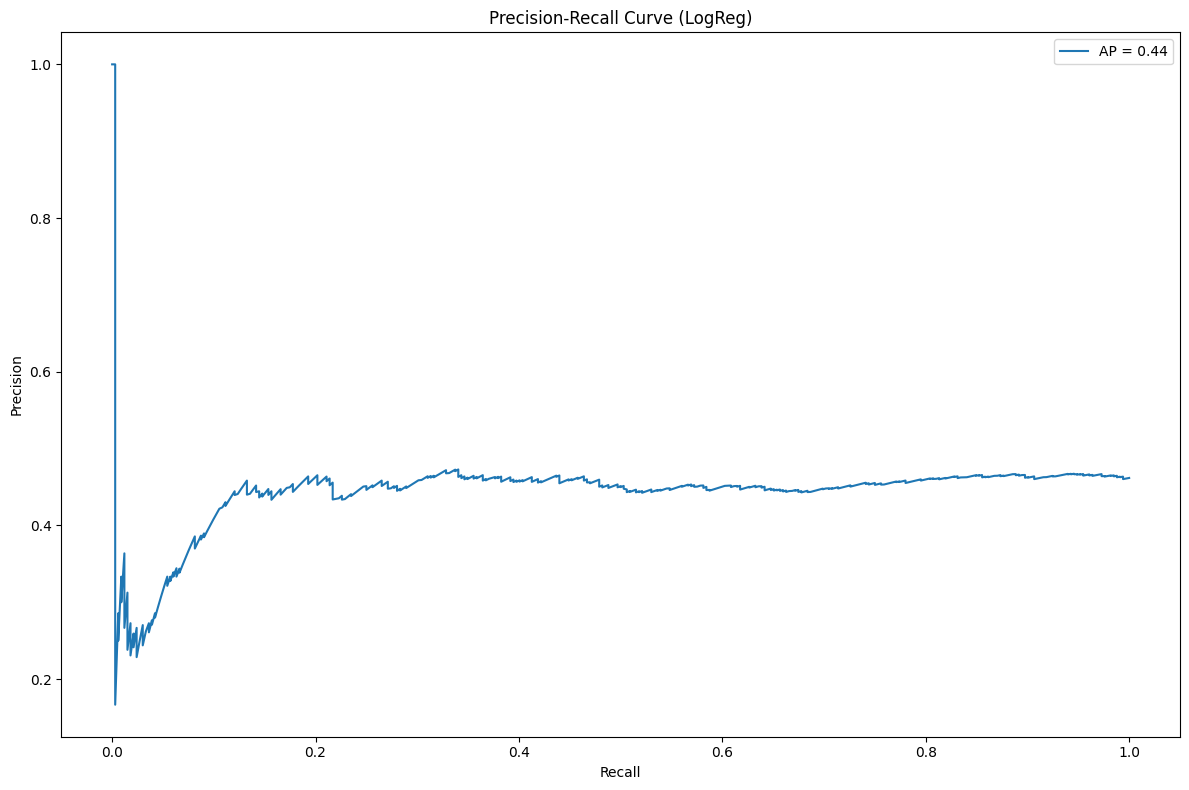

In [ ]:
y_score = clf.decision_function(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_score)
ap = average_precision_score(y_test, y_score)

plt.figure(figsize=(12,8))
plt.plot(recall, precision, label=f'AP = {ap:0.2f}')
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve (LogReg)")
plt.legend(); plt.tight_layout(); plt.show()